# Finetuning SAM 2 for Scientific Figures
This code is adapated from the following:
- [https://www.datacamp.com/tutorial/sam2-fine-tuning](https://www.datacamp.com/tutorial/sam2-fine-tuning)
- [https://learnopencv.com/finetuning-sam2/](https://learnopencv.com/finetuning-sam2/)
- [https://medium.com/data-science/train-fine-tune-segment-anything-2-sam-2-in-60-lines-of-code-928dd29a63b3](https://medium.com/data-science/train-fine-tune-segment-anything-2-sam-2-in-60-lines-of-code-928dd29a63b3)

In [1]:
import os
import json
import random 

import pandas as pd 
import numpy as np

import cv2
import torch
import torch.nn.utils
import torch.nn.functional as F

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
import matplotlib.image as mpimg
import matplotlib.colors as mcolors

from tqdm.notebook import tqdm

In [2]:
def set_seeds():
    SEED_VALUE = 42
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
 
set_seeds()

In [3]:
def read_jsons(input_dir):
    json_files = [
        pos_json for pos_json in os.listdir(input_dir) if pos_json.endswith(".json")
    ]
    output = [{}] * len(json_files)

    # get the image and bounding box
    for index, file in enumerate(json_files):  # [0:1]:
        with open(os.path.join(input_dir, file), "r") as input_file:
            data = json.load(input_file)
            output[index] = {
                "document": data["shapes"][0]["image_name"],
                "component_name": data["name"],
                "image": data["origin_image"],
                "bounding_box": data["shapes"][0]["points"],
            }

            # DEBUGGING
            # if data["origin_image"] == "./dataset/image/W19-6501-Figure4-1.png":
            #     print(index)
            #     print(output[index])
            #     print(file)

    return output


def plot_image_with_bounding_box(data):
    image_path = data["image"]
    bbox_coords = data["bounding_box"][0]  # Assuming one polygon
    component_name = data["component_name"]

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    # Load the image
    img = mpimg.imread(image_path)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original image
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis("on")

    # Plot image with bounding box
    axs[1].imshow(img)
    axs[1].set_title("Image with Bounding Box")

    # Create a polygon patch
    polygon = patches.Polygon(
        bbox_coords, closed=True, edgecolor="red", linewidth=2, facecolor="none"
    )
    axs[1].add_patch(polygon)

    # Optionally annotate the component name at the top-left of the bounding box
    x, y = bbox_coords[0]
    axs[1].text(
        x,
        y - 10,
        component_name,
        color="red",
        fontsize=12,
        path_effects=[PathEffects.withStroke(linewidth=2, foreground="white")],
    )

    axs[1].axis("on")
    plt.tight_layout()
    plt.show()


def convert_box_to_mask(data):
    img = cv2.imread(data["image"])
    box = np.array(data["bounding_box"][0])
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    cv2.fillPoly(mask, pts=[box], color=(255, 0, 0))
    return mask


In [4]:
data_dir = "./dataset/"
train_metadata = os.path.join(data_dir, "train")
val_metadata = os.path.join(data_dir, "val")
images_dir = os.path.join(data_dir, "image")

In [5]:
train_data = read_jsons(train_metadata)
val_data = read_jsons(val_metadata)

print(f"Number training datapoints: {len(train_data)}")
print(f"Number validation datapoints: {len(val_data)}")

Number training datapoints: 13761
Number validation datapoints: 1000


In [6]:
train_data[0]

{'document': '202401243.png',
 'component_name': 'Document Ranker',
 'image': './dataset/image/N18-4017-Figure1-1.png',
 'bounding_box': [[[357, 144], [357, 206], [443, 205], [442, 144]]]}

In [7]:
val_data[0]

{'document': '202406745.png',
 'component_name': 'Transformers',
 'image': './dataset/image/2021.bionlp-1.20-Figure2-1.png',
 'bounding_box': [[[199, 85],
   [199, 121],
   [201, 125],
   [530, 125],
   [533, 122],
   [533, 85],
   [529, 82],
   [202, 82]]]}

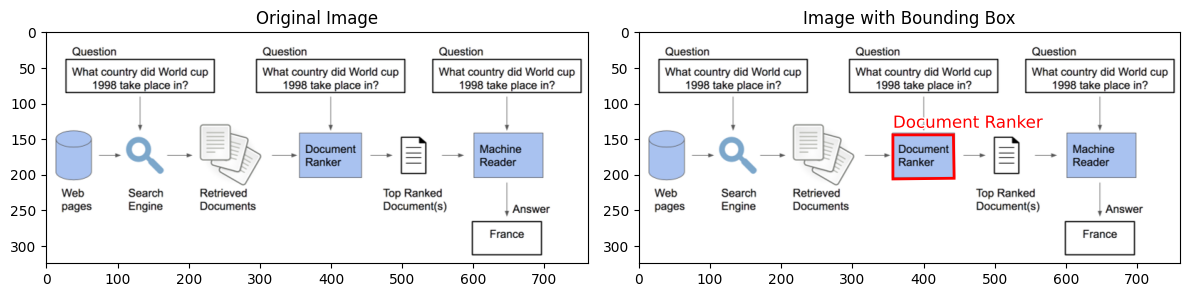

In [8]:
plot_image_with_bounding_box(train_data[0])

In [9]:
def read_batch(data, visualize_data=False):
    ent = data[np.random.randint(len(data))]
    Img = cv2.imread(ent["image"])[...,::-1]
    ann_map = convert_box_to_mask(ent)

    if Img is None or ann_map is None:
        print(
            f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}"
        )
        return None, None, None, 0

    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(
        ann_map,
        (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),
        interpolation=cv2.INTER_NEAREST,
    )

    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []
    inds = np.unique(ann_map)[1:]
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)
        binary_mask = np.maximum(binary_mask, mask)

    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])
    points = np.array(points)

    if visualize_data:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(Img)
        plt.axis("on")

        plt.subplot(1, 3, 2)
        plt.title("Binarized Mask")
        plt.imshow(binary_mask, cmap="gray")
        plt.axis("on")

        plt.subplot(1, 3, 3)
        plt.title("Binarized Mask with Points")
        plt.imshow(binary_mask, cmap="gray")
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100)
        plt.axis("on")

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)
    return Img, binary_mask, points, len(inds), ent


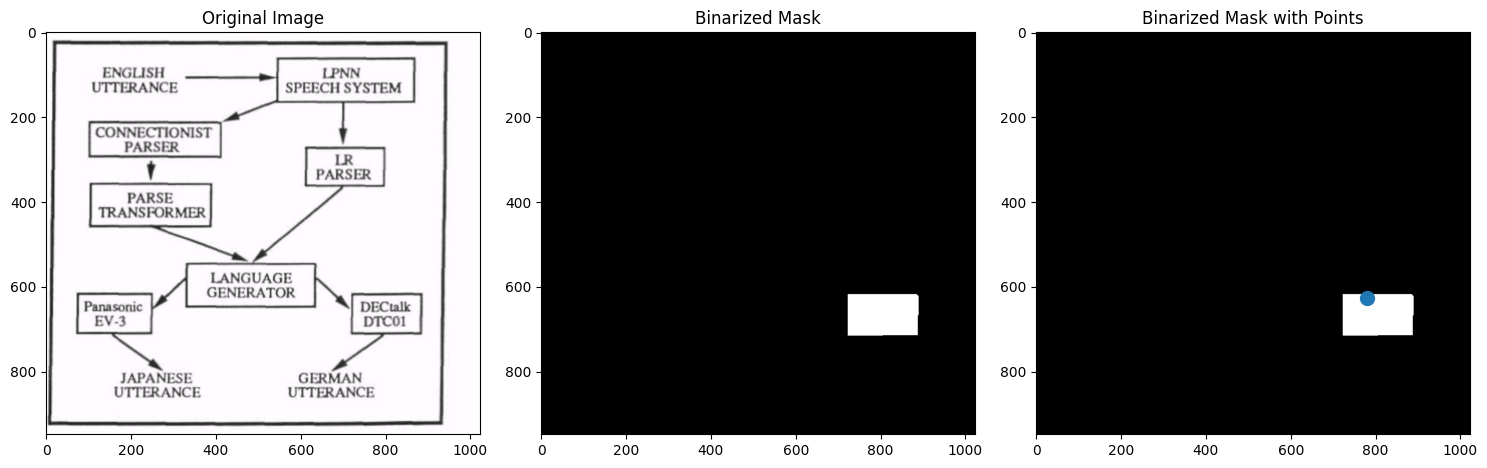

In [10]:
Img1, masks1, points1, num_masks, image_info = read_batch(train_data, visualize_data=True)

In [32]:
def train(predictor, train_data, step, mean_iou):
    with torch.amp.autocast(device_type="cuda"):
        image, mask, input_point, num_masks, image_info = read_batch(
            train_data, visualize_data=False
        )

        if image is None or mask is None or num_masks == 0:
            print("Image or Mask was None")
            return None, None, None, image_info

        input_label = np.ones((num_masks, 1))

        if not isinstance(input_point, np.ndarray) or not isinstance(
            input_label, np.ndarray
        ):
            print("Input label not the right type")
            return None, None, None, image_info

        if input_point.size == 0 or input_label.size == 0:
            print("Input not a coordinate")
            return None, None, None, image_info

        predictor.set_image(image)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
            input_point, input_label, box=None, mask_logits=None, normalize_coords=True
        )

        if (
            unnorm_coords is None
            or labels is None
            or unnorm_coords.shape[0] == 0
            or labels.shape[0] == 0
        ):
            print("Prompt could not be prepared")
            return None, None, None, image_info

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels), boxes=None, masks=None
        )

        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [
            feat_level[-1].unsqueeze(0)
            for feat_level in predictor._features["high_res_feats"]
        ]

        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )

        prd_masks = predictor._transforms.postprocess_masks(
            low_res_masks, predictor._orig_hw[-1]
        )

        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
        prd_mask = torch.sigmoid(prd_masks[:, 0])

        seg_loss = (
            -gt_mask * torch.log(prd_mask + 1e-6)
            - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)
        ).mean()

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)

        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.05

        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

        if step % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            predictor.model.zero_grad()

        scheduler.step()

        # save model
        if step % 500 == 0:
            FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".pt"
            torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

        try:
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
        except Exception as e:
          print(f"An unexpected error occurred: {e}")
          print(
            f"Loss was None -- Image: {train_data['document']} Metadata: {train_data['document']}"
          )

        current_lr = optimizer.param_groups[0]["lr"]
    return mean_iou, current_lr, seg_loss, image_info


In [12]:
def validate(predictor, test_data, step, mean_iou):
    # TODO: I dont think this makes sense for the validation. we probably want to validate on the *entire* validation set
    predictor.model.eval()
    with torch.amp.autocast(device_type="cuda"):
        with torch.no_grad():
            image, mask, input_point, num_masks, image_info = read_batch(
                test_data, visualize_data=False
            )

            if image is None or mask is None or num_masks == 0:
                print("Image or Mask was None")
                return None, None, None, image_info

            input_label = np.ones((num_masks, 1))

            if not isinstance(input_point, np.ndarray) or not isinstance(
                input_label, np.ndarray
            ):
                print("Input label not the right type")
                return None, None, None, image_info

            if input_point.size == 0 or input_label.size == 0:
                print("Input not a coordinate")
                return None, None, None, image_info

            predictor.set_image(image)
            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                input_point,
                input_label,
                box=None,
                mask_logits=None,
                normalize_coords=True,
            )

            if (
                unnorm_coords is None
                or labels is None
                or unnorm_coords.shape[0] == 0
                or labels.shape[0] == 0
            ):
                print("Prompt could not be prepared")
                return None, None, None, image_info

            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=(unnorm_coords, labels), boxes=None, masks=None
            )

            batched_mode = unnorm_coords.shape[0] > 1
            high_res_features = [
                feat_level[-1].unsqueeze(0)
                for feat_level in predictor._features["high_res_feats"]
            ]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=batched_mode,
                high_res_features=high_res_features,
            )

            prd_masks = predictor._transforms.postprocess_masks(
                low_res_masks, predictor._orig_hw[-1]
            )

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])

            seg_loss = (
                -gt_mask * torch.log(prd_mask + 1e-6)
                - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)
            ).mean()

            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (
                gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter
            )

            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss = seg_loss + score_loss * 0.05
            loss = loss / accumulation_steps

            try:
                mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            except Exception as e:
              print(f"An unexpected error occurred: {e}")
              print(
                f"Loss was None -- Image: {test_data['document']} Metadata: {test_data['document']}"
              )

            current_lr = optimizer.param_groups[0]["lr"]
    return mean_iou, current_lr, seg_loss, image_info

In [13]:
# Load SAM Model and prepare for training
sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "sam2.1_hiera_l.yaml"
 
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

# predictor.model.image_encoder.train(True)
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)

scaler = torch.amp.GradScaler()
NO_OF_STEPS = 32000
FINE_TUNED_MODEL_NAME = "./finetuned-models/fine_tuned_sam2"
 
optimizer = torch.optim.AdamW(params=predictor.model.parameters(),
                              lr=0.00005,
                              weight_decay=1e-4)
 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.6)
accumulation_steps = 8

# store training output
output = [{}] * NO_OF_STEPS
train_mean_iou = 0
valid_mean_iou = 0

for step in tqdm(range(1, NO_OF_STEPS + 1)):
    new_train_mean_iou, train_lr, train_seg_loss, train_image_info = train(predictor, train_data, step, train_mean_iou)
    new_valid_mean_iou, val_lr, val_seg_loss, val_image_info = validate(predictor, val_data, step, valid_mean_iou)

    if new_train_mean_iou is not None:
        train_mean_iou = new_train_mean_iou
    if new_valid_mean_iou is not None:
        valid_mean_iou = new_valid_mean_iou

    # track iou and loss
    if all(v is not None for v in [train_lr, train_seg_loss, val_lr, val_seg_loss]):
        # update output
        output[step - 1] = {
            "train": {
                "mean_iou": float(train_mean_iou),
                "train_lr": train_lr,
                "seg_loss": float(train_seg_loss.item()),
            },
            "validate": {
                "mean_iou": float(valid_mean_iou),
                "train_lr": val_lr,
                "seg_loss": float(val_seg_loss.item()),
            }
        }

        # print status
        output_str = f"Train: {train_image_info['document']} / {train_image_info['image']} | Validate: {val_image_info['document']} / {val_image_info['image']}"
        if step % 100 == 0:
            print(f"Step {step} -- Train: Current LR = {train_lr:.6f}, Train IoU = {train_mean_iou:.6f}, Train Seg Loss = {train_seg_loss:.6f} || Current LR = {val_lr:.6f}, Valid IoU = {valid_mean_iou:.6f}, Valid Seg Loss = {val_seg_loss:.6f}")
            
        print(
            "{:<300}".format(output_str), end='\r'
        )

  0%|          | 0/32000 [00:00<?, ?it/s]

/home/kapilg/.local/share/virtualenvs/sam2-figures-new-Bvxz5dCi/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 100 -- Train: Current LR = 0.000050, Train IoU = 0.312550, Train Seg Loss = 0.008852 || Current LR = 0.000050, Valid IoU = 0.247561, Valid Seg Loss = 0.012940                                                                                                                                         
Step 200 -- Train: Current LR = 0.000050, Train IoU = 0.484813, Train Seg Loss = 2.902749 || Current LR = 0.000050, Valid IoU = 0.430438, Valid Seg Loss = 0.004677                                                                                                                                         
Step 300 -- Train: Current LR = 0.000050, Train IoU = 0.604438, Train Seg Loss = 0.007884 || Current LR = 0.000050, Valid IoU = 0.577849, Valid Seg Loss = 0.007908                                                                                                                                         
Step 400 -- Train: Current LR = 0.000050, Train IoU = 0.697977, Train Seg Loss = 0.049360 || Curr

In [14]:
with open(f'./finetuned-models/training-log_sam2.1_hiera_large_{NO_OF_STEPS}-epochs_2000-step_06-gamma_{accumulation_steps}-acc.json', 'w') as f:
    json.dump(output, f)

### Plot Loss

In [31]:
output[0:5]

[{'train': {'mean_iou': 0.00014462809485848993,
   'train_lr': 5e-05,
   'seg_loss': 0.5001726746559143},
  'validate': {'mean_iou': 0.0015868948539718986,
   'train_lr': 5e-05,
   'seg_loss': 0.06086408346891403}},
 {'train': {'mean_iou': 0.0015478564891964197,
   'train_lr': 5e-05,
   'seg_loss': 0.0686357244849205},
  'validate': {'mean_iou': 0.002340865321457386,
   'train_lr': 5e-05,
   'seg_loss': 0.15185391902923584}},
 {'train': {'mean_iou': 0.00215293001383543,
   'train_lr': 5e-05,
   'seg_loss': 0.13343504071235657},
  'validate': {'mean_iou': 0.0023540137335658073,
   'train_lr': 5e-05,
   'seg_loss': 2.8633205890655518}},
 {'train': {'mean_iou': 0.010834949091076851,
   'train_lr': 5e-05,
   'seg_loss': 0.02088831178843975},
  'validate': {'mean_iou': 0.002973277820274234,
   'train_lr': 5e-05,
   'seg_loss': 0.07279520481824875}},
 {'train': {'mean_iou': 0.01236685086041689,
   'train_lr': 5e-05,
   'seg_loss': 0.09192506968975067},
  'validate': {'mean_iou': 0.0032675419

## Check model against test set

In [16]:
test_metadata = os.path.join(data_dir, "test")
test_data = read_jsons(test_metadata)
print(f"Number testing datapoints: {len(test_data)}")

Number testing datapoints: 1000


In [17]:
test_data[0]

{'document': '202405001.png',
 'component_name': 'Refresh OLiA',
 'image': './dataset/image/L16-1707-Figure4-1.png',
 'bounding_box': [[[68, 787],
   [68, 797],
   [71, 801],
   [71, 807],
   [87, 822],
   [196, 822],
   [199, 819],
   [205, 817],
   [214, 805],
   [214, 780],
   [200, 766],
   [195, 766],
   [193, 764],
   [92, 764],
   [85, 766],
   [81, 770],
   [77, 771],
   [75, 776],
   [71, 780],
   [70, 786]]]}

In [23]:
test_mean_iou = 0
test_output = [{}] * len(test_data)

for index, test_image in enumerate(tqdm(test_data)):
    # run each image through validation
    new_test_mean_iou, test_lr, test_seg_loss, test_image_info  = validate(predictor, [test_image], index + 1, test_mean_iou)
    if new_test_mean_iou is not None:
        test_mean_iou = new_test_mean_iou

    # track iou and loss
    if all(v is not None for v in [test_lr, test_seg_loss]):
        # update output
        test_output[index] = {
            "test": {
                "mean_iou": float(test_mean_iou),
                "train_lr": test_lr,
                "seg_loss": float(test_seg_loss.item()),i
            }
        }

        # print status
        output_str = f"Test: {test_image_info['document']} / {test_image_info['image']}"
        if (index + 1) % 100 == 0:
            print(f"Test: Current LR = {test_lr:.6f}, IoU = {test_mean_iou:.6f}, Train Seg Loss = {test_seg_loss:.6f}")
            
        print(
            "{:<300}".format(output_str), end='\r'
        )

  0%|          | 0/1000 [00:00<?, ?it/s]

Test: Current LR = 0.000000, IoU = 0.583332, Train Seg Loss = 0.001608                                                                                                                                                                                                                                      
Test: Current LR = 0.000000, IoU = 0.794213, Train Seg Loss = 0.004364                                                                                                                                                                                                                                      
Test: Current LR = 0.000000, IoU = 0.879112, Train Seg Loss = 0.000822                                                                                                                                                                                                                                      
Test: Current LR = 0.000000, IoU = 0.909972, Train Seg Loss = 0.003057                           

In [29]:
test_output[0:5]

[{'test': {'mean_iou': 0.009627319872379303,
   'train_lr': 2.3509249228799996e-08,
   'seg_loss': 0.000868240837007761}},
 {'test': {'mean_iou': 0.019109927117824554,
   'train_lr': 2.3509249228799996e-08,
   'seg_loss': 0.002877257764339447}},
 {'test': {'mean_iou': 0.02844502031803131,
   'train_lr': 2.3509249228799996e-08,
   'seg_loss': 0.00695078307762742}},
 {'test': {'mean_iou': 0.03769838437438011,
   'train_lr': 2.3509249228799996e-08,
   'seg_loss': 0.0011951139895245433}},
 {'test': {'mean_iou': 0.04698356240987778,
   'train_lr': 2.3509249228799996e-08,
   'seg_loss': 0.007698310539126396}}]